In [51]:
# Visualize results

import torch
import slayerSNN as snn
from dataset import ViTacDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [52]:
# Tactile data

In [66]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10,
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: 150, False: 3},
        }
    },
}

In [82]:
from snn_models.baseline_snn import SlayerMLP
from torch.utils.data import DataLoader

input_size = 156  # Tact
hidden_size = 32
output_size = 20
batch_size = 8
sample_file = 3
data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'

device = torch.device("cuda")

train_dataset = ViTacDataset(
    path=data_dir, sample_file=f"train_80_20_{sample_file}.txt"
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt"
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

net = SlayerMLP(params, input_size, hidden_size, output_size).to(device)
net.load_state_dict(torch.load('logged_models/weights-500-33.628.pt'))
net.eval()

error = snn.loss(params).to(device)

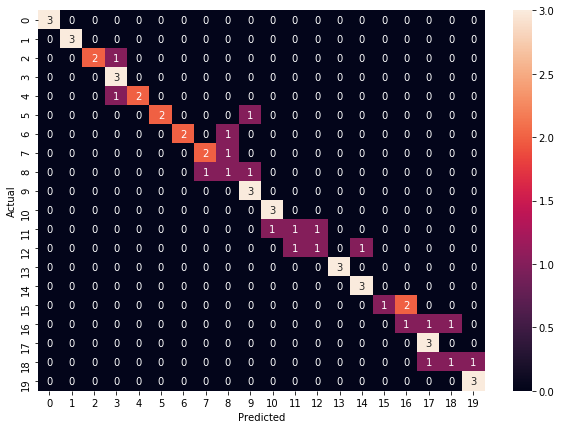

In [83]:
count = 0
testing_true = torch.zeros([len(test_dataset),2])
for i, (input_tact_left, _, target, label) in enumerate(test_loader, 0):
    testing_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        input_tact_left = input_tact_left.to(device)
        out_tact = net.forward(input_tact_left)
        predicted_label = snn.predict.getClass(out_tact)
        testing_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy())
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(ref_name + \"_test.png\")
plt.show()

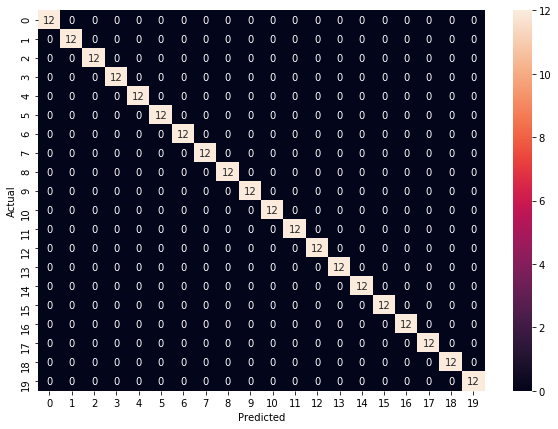

In [84]:
count = 0
training_true = torch.zeros([len(train_dataset),2])
for i, (input_tact_left, _, target, label) in enumerate(train_loader, 0):
    training_true[count:count+label.shape[0],0] = label
    with torch.no_grad():
        # Forward pass of the network.
        input_tact_left = input_tact_left.to(device)
        out_tact = net.forward(input_tact_left)
        predicted_label = snn.predict.getClass(out_tact)
        training_true[count:count+label.shape[0],1] = predicted_label
    count += label.shape[0]
cm = confusion_matrix(training_true[:,0].numpy(), training_true[:,1].numpy())
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(ref_name + \"_test.png\")
plt.show()

In [85]:
accuracy_score(testing_true[:,0].numpy(), testing_true[:,1].numpy())

0.7166666666666667

In [86]:
accuracy_score(training_true[:,0].numpy(), training_true[:,1].numpy())

1.0